In [22]:
pip install gym numpy matplotlib

In [23]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time

In [24]:
# Baseline SoTA reward function
def SoTARewardFunction(observation, action):
    x, _, theta, _ = observation
    
    if abs(theta) > np.deg2rad(15) or abs(x) > 2.4:
        return 0
    
    return 1

# Example LLM-generated reward functions
def LLMRewardFunction1API(observation, action):
    x, _, angle, _ = observation
    reward = 1.0 - abs(angle) - 0.5 * abs(x)
    return max(0, reward)

def LLMRewardFunction2API(observation, action):
    x, _, angle, _ = observation
    reward = 1.0
    
    if abs(x) > 2.4 or abs(angle) > 0.2:
        reward = -10.0
    else:
        reward += 10.0 / (1.0 + abs(angle))
        reward += 5.0 / (1.0 + abs(x))
    
    return int(reward)


def LLMRewardFunction1(observation, action):
    # Unpack state variables
    x, x_dot, angle, angle_dot = observation
    
    # Define constants
    x_threshold = 2.4  # Cart position limit
    angle_threshold = 12 * np.pi / 180  # Angle limit (12 degrees)
    
    # Check if episode is done
    done = bool(
        abs(x) > x_threshold or
        abs(angle) > angle_threshold
    )
    
    if not done:
        # Reward for pole angle (closer to vertical is better)
        angle_reward = 1 - abs(angle) / angle_threshold
        
        # Reward for cart position (closer to center is better)
        position_reward = 1 - abs(x) / x_threshold
        
        # Reward for keeping the pole stable
        stability_reward = 1 / (1 + abs(angle_dot))
        
        # Combine rewards
        reward = angle_reward + position_reward + stability_reward
    else:
        # Penalty for ending episode
        reward = -10
    
    return reward


def LLMRewardFunction2(observation, action):
    # Unpack state variables
    x, x_dot, angle, angle_dot = observation
    
    # System parameters (now hardcoded as they can't be passed in)
    m = 0.1  # pendulum mass
    M = 1.0  # cart mass
    l = 0.5  # pendulum length
    g = 9.8  # gravity
    
    # Calculate potential energy
    PE = m * g * l * (1 - np.cos(angle))
    
    # Calculate kinetic energy
    KE_cart = 0.5 * M * x_dot**2
    KE_pendulum = 0.5 * m * ((x_dot**2) + (l * angle_dot**2) + 
                             (2 * x_dot * l * angle_dot * np.cos(angle)))
    KE_total = KE_cart + KE_pendulum
    
    # Calculate total energy
    E_total = PE + KE_total
    
    # Define reward components
    energy_reward = -E_total  # Minimize total energy
    stability_reward = -abs(angle)  # Minimize angle deviation
    
    # Combine rewards (adjusted weights since we can't measure control effort now)
    reward = 0.7 * energy_reward + 0.3 * stability_reward
    
    # Check if episode is done
    x_threshold = 2.4
    angle_threshold = np.pi / 2
    done = bool(
        abs(x) > x_threshold or
        abs(angle) > angle_threshold
    )
    
    if done:
        reward -= 100  # Large penalty for ending episode
    
    return reward


#---

# Train the agent using Q-learning
def train(env, agent, reward_model, episodes=500):
    rewards = []
    for episode in range(episodes):
        observation = env.reset()[0]
        state = agent.discretize(observation)
        total_reward = 0
        done = False
        while not done:
            action = agent.choose_action(state)
            next_observation, reward, done, _, _ = env.step(action)
            adjusted_reward = reward_model(next_observation, reward)
            next_state = agent.discretize(next_observation)
            agent.update(state, action, adjusted_reward, next_state)
            state = next_state
            total_reward += adjusted_reward
        rewards.append(total_reward)
    return rewards



# episodes = 10000
# baselineRewards = train(env, agent, SoTARewardFunction, episodes)
# LLM1Rewards = train(env, agent, LLMRewardFunction1, episodes)
# LLM2Rewards = train(env, agent, LLMRewardFunction2, episodes)

# # Plot results
# plt.plot(np.arange(episodes), LLM2Rewards, label="2nd LLM-Generated Reward Model")
# plt.plot(np.arange(episodes), baselineRewards, label="Custom Baseline Reward Model")
# plt.plot(np.arange(episodes), LLM1Rewards, label="1st LLM-Generated Reward Model")

# plt.xlabel("Episodes")
# plt.ylabel("Total Reward")

# plt.title("Reward Comparison over Time")

# plt.legend()
# plt.show()


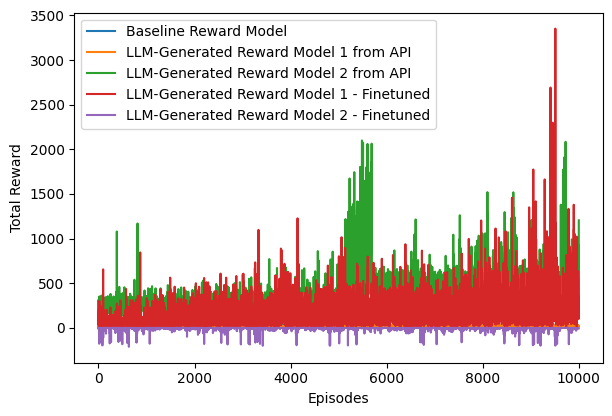

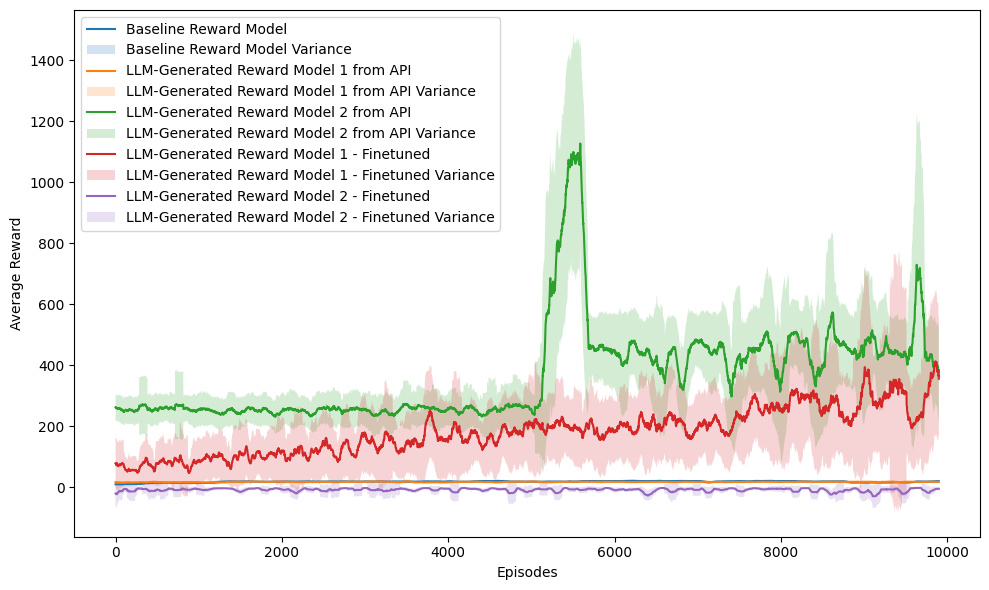

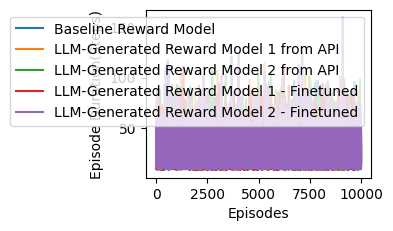

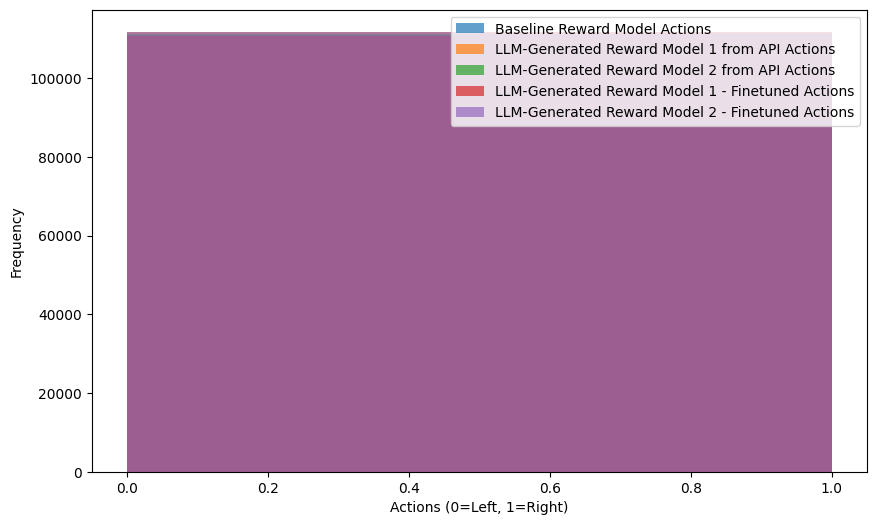

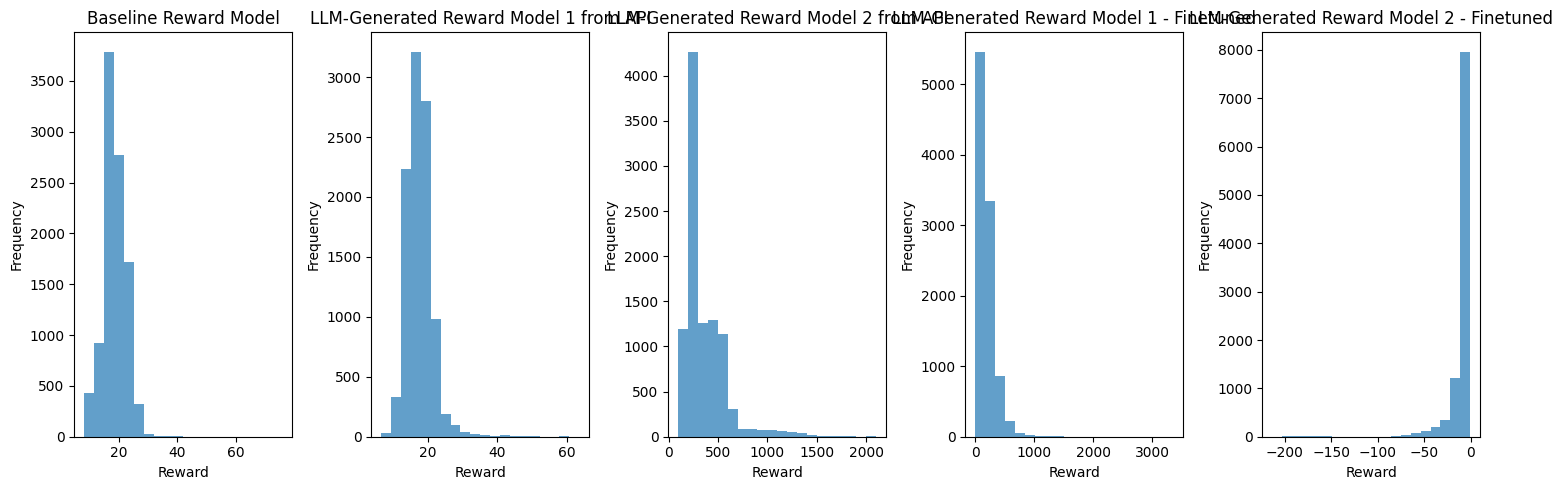

In [25]:
# Takes ~ 60 second to run
from cartPoleShared import QLearningAgent


env = gym.make('CartPole-v1')
agent = QLearningAgent(env)


#This is temporary until I fix the error with the update function not being defined inthe calss
def update(self, state, action, reward, next_state):
    best_next_action = np.argmax(self.q_table[next_state])
    td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
    td_error = td_target - self.q_table[state][action]
    self.q_table[state][action] += self.learning_rate * td_error

QLearningAgent.update = update




def movingAverageAndStd(data, windowSize=100):
    average = np.convolve(data, np.ones(windowSize) / windowSize, mode='valid')
    std = [np.std(data[i:i+windowSize]) for i in range(len(data) - windowSize + 1)]
    return average, std




# List of reward functions to abstract repeated calls
rewardFunctions = [
    ("Baseline Reward Model", SoTARewardFunction),
    ("LLM-Generated Reward Model 1 from API", LLMRewardFunction1API),
    ("LLM-Generated Reward Model 2 from API", LLMRewardFunction2API),
    ("LLM-Generated Reward Model 1 - Finetuned", LLMRewardFunction1),
    ("LLM-Generated Reward Model 2 - Finetuned", LLMRewardFunction2)

]

# Store results in a dictionary
rewardsDict = {}

# Run experiments for each reward function
episodes = 10000
for label, reward_fn in rewardFunctions:
    rewardsDict[label] = train(env, agent, reward_fn, episodes)


plt.figure(figsize=(15, 10))


#Total Reward Comparison
plt.subplot(2, 2, 1)
for label, rewards in rewardsDict.items():
    plt.plot(np.arange(episodes), rewards, label=label)


plt.xlabel("Episodes")
plt.ylabel("Total Reward")

plt.legend()

# 2.Running Average of Rewards

# avgBaseline, stdBaseline = movingAverageAndStd(baselineRewards, windowSize=100)
# avgLLM1, stdLLM1 = movingAverageAndStd(LLM1Rewards, windowSize=100)
# avgLLM2, stdLLM2 = movingAverageAndStd(LLM2Rewards, windowSize=100)

plt.figure(figsize=(10, 6))


for label, rewards in rewardsDict.items():
    avg, std = movingAverageAndStd(rewards, windowSize=100)
    plt.plot(np.arange(len(avg)), avg, label=label)
    plt.fill_between(np.arange(len(avg)), avg - std, avg + std, alpha=0.2, label=f"{label} Variance")


plt.xlabel("Episodes")
plt.ylabel("Average Reward")


plt.legend()
plt.tight_layout()
plt.show()

# 3. Episode Duration
# def episodeDuration(env, rewardModel, episodes=500):
#     durations = []
#     for episode in range(episodes):
#         observation = env.reset()
#         done = False
#         duration = 0

#         while not done:
#             action = env.action_space.sample()
#             observation, reward, done, _, _ = env.step(action)
#             duration += 1  
#         durations.append(duration)

#     return durations

# # Get the episode durations
# durationsDict = {label: episodeDuration(env, reward_fn, episodes) for label, reward_fn in rewardFunctions}


# # Plot Episode Duration
# plt.subplot(2, 2, 3)
# for label, durations in durationsDict.items():
#     plt.plot(np.arange(episodes), durations, label=label)


# plt.xlabel("Episodes")
# plt.ylabel("Episode Duration(Steps)")
# plt.legend()

# 4.action distribution
def getActionDistributions(env, rewardModels, episodes):
    actionDistributions = {}

    # Iterate through the list of tuples where each tuple is (rewardModelName, rewardModel)
    for rewardModelName, rewardModel in rewardModels:
        actions = []
        for episode in range(episodes):
            observation = env.reset()[0]
            done = False

            while not done:
                action = env.action_space.sample()  # Use agent's policy instead if needed
                actions.append(action)
                observation, _, done, _, _ = env.step(action)

        actionDistributions[rewardModelName] = actions  # Store the actions for this reward model

    return actionDistributions



actionDistributions = getActionDistributions(env, rewardFunctions, episodes)

# Plot action distributions
plt.figure(figsize=(10, 6))
for rewardModelName, actions in actionDistributions.items():
    plt.hist(actions, bins=2, alpha=0.7, label=f"{rewardModelName} Actions")

plt.xlabel("Actions (0=Left, 1=Right)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# 5. Reward Distribution
plt.figure(figsize=(15, 5))

# Plot for Baseline Rewards
for i, (label, rewards) in enumerate(rewardsDict.items(), 1):
    plt.subplot(1, len(rewardsDict.items()), i)
    plt.hist(rewards, bins=20, alpha=0.7)
    plt.title(label)
    plt.xlabel("Reward")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


# 6. Success Rate Calc
# successThreshold = 200

# baselineSuccessRate = sum([1 if r >= successThreshold else 0 for r in baselineRewards]) / episodes
# llmSuccessRate1 = sum([1 if r >= successThreshold else 0 for r in LLM1Rewards]) / episodes
# llmSuccessRate2 = sum([1 if r >= successThreshold else 0 for r in LLM2Rewards]) / episodes

# print(f"Baseline Success Rate: {baselineSuccessRate * 100:.2f}%")
# print(f"LLM-Generated Success Rate 1: {llmSuccessRate1 * 100:.2f}%")
# print(f"LLM-Generated Success Rate 2: {llmSuccessRate2 * 100:.2f}%")



In [26]:



def visualizeSuccessfulRuns(env, rewards_dict, durations_dict):
    
    # longest_runs_indices = np.argsort(durations)[-20:]  

    env = gym.make('CartPole-v1', render_mode="human")
    agent = QLearningAgent(env)

    for rewardModelName, rewards in rewards_dict.items():
        durations = durations_dict[rewardModelName]
        longest_runs_indices = np.argsort(durations)[-20:] # Get the indices of the top 20 longest runs

        for idx in longest_runs_indices:
            # print(f"Duration: {durations[idx]}, Reward: {rewards[idx]}")



            observation, _ = env.reset()
            state = agent.discretize(observation)
            done = False


            # print(f"{rewardModelName} - Run {idx+1}")

            while not done:
                action = agent.choose_action(state)
                next_observation, reward, done, _, _ = env.step(action)
                next_state = agent.discretize(next_observation)
                state = next_state

                # Render environment
                env.render()

                time.sleep(0.01)

        print(f"Next Model: {rewardModelName}")

    env.close()




visualizeSuccessfulRuns(env, rewardsDict, durationsDict)


Next Model: Baseline Reward Model
Next Model: LLM-Generated Reward Model 1 from API
Next Model: LLM-Generated Reward Model 2 from API
Next Model: LLM-Generated Reward Model 1 - Finetuned
Next Model: LLM-Generated Reward Model 2 - Finetuned


In [27]:
#Maybe run many instances of reward models generated by Claude. Compare, with SoTA as baseline

Can also add an explainability metric


Prompt Engineering:

Keep a log of the interaction with Claude. To see the developemnt. (See how these perform, run compute experiements)


Eventually:(These can be developed by Claude)
Adaptive learning rate 
Adaptive Reward Function



Adaptive reward function for changes in enviornment. For example change the weight of the pole, add friction. How does the reward function adapt?





